# Classification by standard ML approach
In the following, we will run some experiments using some of the standard ML approaches, such as Random Forest, MLP, SVMs. These naïve methods will exploit the list of ingredients, rather than the structure of the entire recipe itself. This reasoning comes up naturally when considering such standards ML practices, since they do not keep in consideration the semantic structure of the sentences and do not share any weight in the network

### Imports

In [1]:
from tqdm.auto import tqdm
import seaborn as sns

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.tree import export_text
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.neural_network import BernoulliRBM, MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

### Data loading

In [3]:
PATH_DATA = './dataset/ingredients_list_stanza_10k.csv'
PATH_VOCABULARY = './dataset/vocabulary_stanza_10k.csv'
PATH_RECIPES = './dataset/dataset_balanced_10k.csv'

data = pd.read_csv(PATH_DATA, low_memory=False)
vocabulary = pd.read_csv(PATH_VOCABULARY)

In [4]:
recipes = pd.read_csv(PATH_RECIPES)
labels = recipes['Vegetarian']

### Preprocessing
We need to create the one_hot_encoded version of the ingredients, both for the ingredient's vocabulary and for the matrix of recipes.

In [5]:
vocabulary = vocabulary.fillna('Missing')
ohe_vocabulary = pd.get_dummies(vocabulary, prefix='category').astype(int)

In [6]:
ohe_matrix = []

# Loop over each recipe in the data
for index, recipe in data.iterrows():
    ohe_recipe = np.zeros(len(ohe_vocabulary.columns))
    
    for ingredient in recipe:
        if pd.isnull(ingredient):
            continue
        
        # Check if the ingredient is in the one-hot vocabulary
        if f'category_{ingredient}' in ohe_vocabulary.columns:
            # Find the index for the ingredient
            ingredient_index = ohe_vocabulary.columns.get_loc(f'category_{ingredient}')
            
            # Set the corresponding position in ohe_recipe to 1
            ohe_recipe[ingredient_index] = 1

    ohe_matrix.append(ohe_recipe)

ohe_matrix = np.array(ohe_matrix)

In [7]:
labels = labels.to_numpy()

## Classification

In [8]:
X_train, X_test, y_train, y_test = train_test_split(ohe_matrix, labels, test_size=0.3, random_state=42, stratify=labels)

In [9]:
unique, counts = np.unique(labels, return_counts=True)
print(dict(zip(unique, counts)))

{0: 5000, 1: 5000}


In [10]:
unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))

{0: 3500, 1: 3500}


In [11]:
unique, counts = np.unique(y_test, return_counts=True)
print(dict(zip(unique, counts)))

{0: 1500, 1: 1500}


### Random Forest
Let's start with a random configuration of hyperparameters.

In [15]:
random_forest = RandomForestClassifier(criterion='gini', n_estimators=100, random_state=42, max_depth=None, min_samples_split=5, min_samples_leaf=1, n_jobs=-1)
random_forest.fit(X_train, y_train)
y_pred = random_forest.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.871
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.85      0.87      1500
           1       0.86      0.89      0.87      1500

    accuracy                           0.87      3000
   macro avg       0.87      0.87      0.87      3000
weighted avg       0.87      0.87      0.87      3000



Confusion Matrix:
[[1275  225]
 [ 162 1338]]


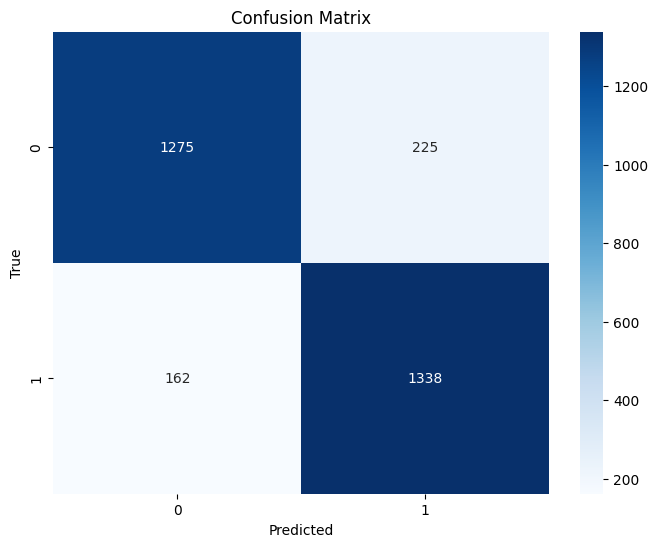

In [13]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=np.unique(labels), yticklabels=np.unique(labels))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Now we perform a small grid search to find the best configuration.

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]  
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

Now we apply the best configuration of parameters.

In [27]:
best_rf = grid_search.best_estimator_

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

Accuracy: 0.8726666666666667
Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation score: 0.88


In [16]:
random_forest = RandomForestClassifier(n_estimators=200, random_state=42, max_depth=None, min_samples_split=2, min_samples_leaf=1)
random_forest.fit(X_train, y_train)

# test the model
y_pred = random_forest.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.8723333333333333
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.84      0.87      1500
           1       0.85      0.90      0.88      1500

    accuracy                           0.87      3000
   macro avg       0.87      0.87      0.87      3000
weighted avg       0.87      0.87      0.87      3000



Confusion Matrix:
[[1265  235]
 [ 148 1352]]


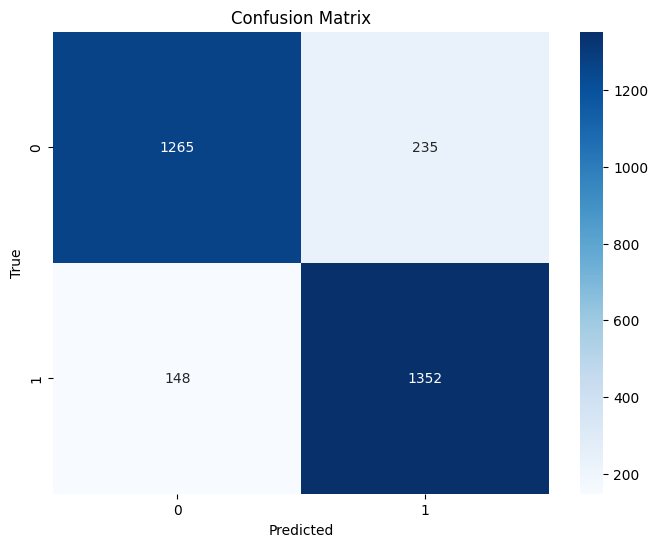

In [17]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=np.unique(labels), yticklabels=np.unique(labels))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### MLP
Again, let's begin with a random configuration.

In [18]:
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, alpha=0.0001,
                    solver='adam', verbose=False, random_state=21, learning_rate_init=0.01)

mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.86      0.89      1500
           1       0.87      0.93      0.90      1500

    accuracy                           0.90      3000
   macro avg       0.90      0.90      0.90      3000
weighted avg       0.90      0.90      0.90      3000

Accuracy Score: 0.8976666666666666


Confusion Matrix:
[[1292  208]
 [  99 1401]]


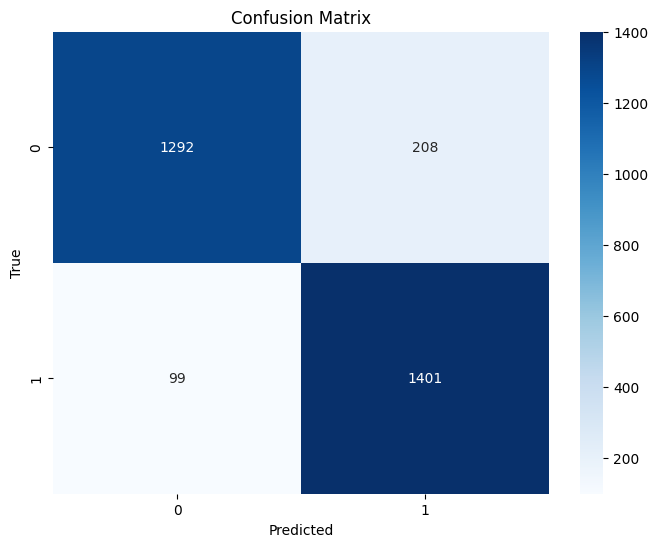

In [19]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=np.unique(labels), yticklabels=np.unique(labels))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Then, we make a grid search.

In [ ]:
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50), (150, 100, 50)],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.001, 0.01, 0.1]
}

mlp = MLPClassifier(max_iter=300, random_state=21, verbose=10)
grid_search = GridSearchCV(estimator=mlp, param_grid=param_grid, cv=3, n_jobs=-1, verbose=10)
grid_search.fit(X_train, y_train)

In [22]:
print("Best parameters found: ", grid_search.best_params_)

Best parameters found:  {'alpha': 0.01, 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.001}


And now we apply the best configuration.

In [23]:
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, alpha=0.01,
                    solver='adam', verbose=False, random_state=21, learning_rate_init=0.001)

mlp.fit(X_train, y_train)

# test the model
y_pred = mlp.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.86      0.90      1500
           1       0.87      0.94      0.91      1500

    accuracy                           0.90      3000
   macro avg       0.90      0.90      0.90      3000
weighted avg       0.90      0.90      0.90      3000

Accuracy Score: 0.9016666666666666


Confusion Matrix:
[[1293  207]
 [  88 1412]]


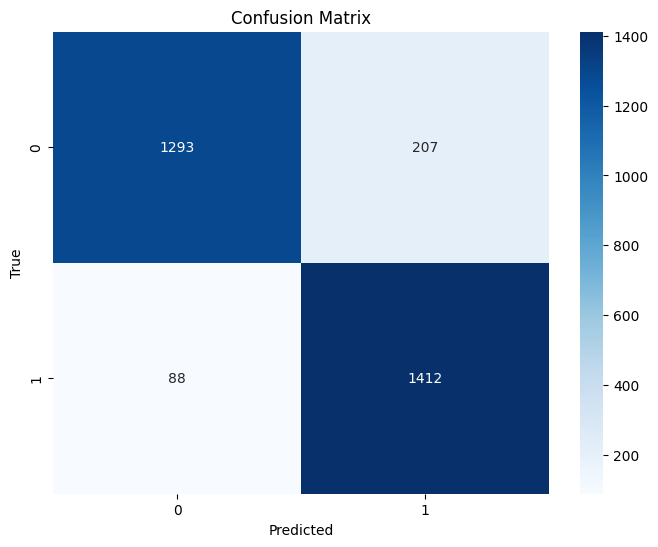

In [24]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=np.unique(labels), yticklabels=np.unique(labels))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### SVM
We start with a random configuration.

In [25]:
svc = SVC(C=100, kernel='rbf', gamma=0.001)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.83      0.89      1500
           1       0.85      0.97      0.91      1500

    accuracy                           0.90      3000
   macro avg       0.91      0.90      0.90      3000
weighted avg       0.91      0.90      0.90      3000



Confusion Matrix:
[[1246  254]
 [  44 1456]]


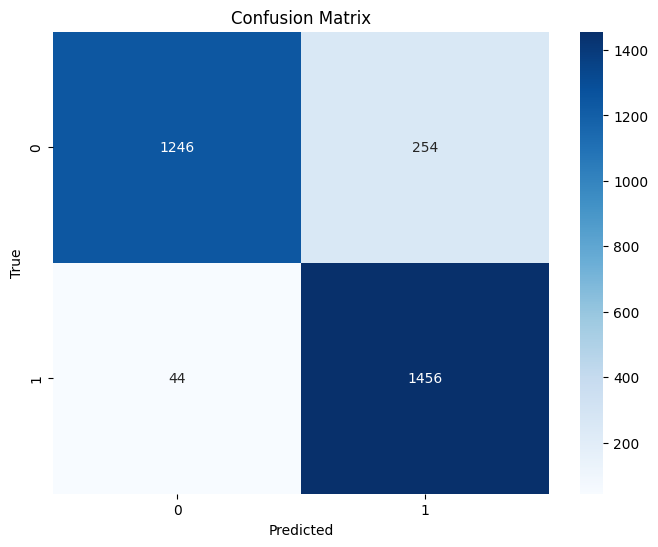

In [26]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=np.unique(labels), yticklabels=np.unique(labels))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

An again a small grid search.

In [ ]:
param_grid = [
    {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
]

svc = SVC()
grid_search = GridSearchCV(svc, param_grid, cv=5, scoring='accuracy', verbose=10, n_jobs=-1)
grid_search.fit(X_train, y_train)

In [31]:
best_svm = grid_search.best_estimator_
y_pred = best_svm.predict(X_test)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

Best parameters: {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
Best cross-validation score: 0.92


An we apply it to our test set.

In [27]:
svc = SVC(C = 1000, kernel = 'rbf', gamma = 0.001)
svc.fit(X_train, y_train)

# test the model
y_pred = svc.predict(X_test)

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Test Accuracy: 0.9146666666666666
              precision    recall  f1-score   support

           0       0.96      0.87      0.91      1500
           1       0.88      0.96      0.92      1500

    accuracy                           0.91      3000
   macro avg       0.92      0.91      0.91      3000
weighted avg       0.92      0.91      0.91      3000



Confusion Matrix:
[[1299  201]
 [  55 1445]]


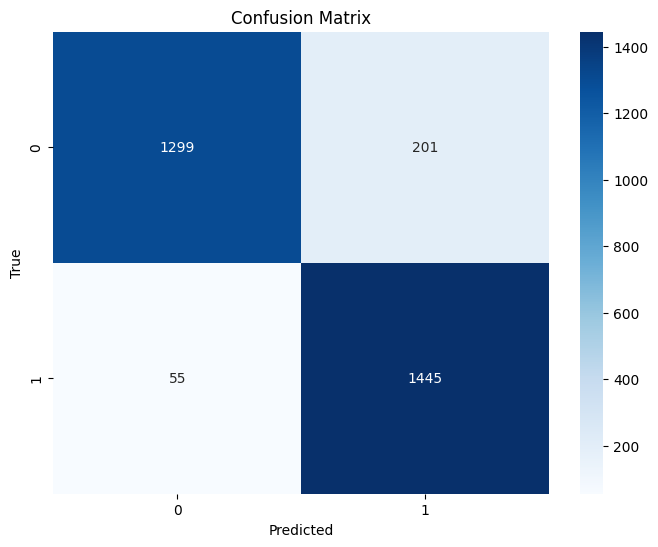

In [28]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=np.unique(labels), yticklabels=np.unique(labels))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()